# Inclass Kaggle competition week 4


### <span style="color:#0b486b"> II.0 Running on Google Colab</span> <span style="color:red"></span>
You will need to download relevant files to run this notebook on Google Colab.

In [40]:
# Comment out this line of code if you have already run it once

# !gdown https://drive.google.com/file/d/1a5zemCw89Tp20fEofPAmJt2HisqMKrnF/view?usp=sharing --fuzzy -O KW4.zip
# !gdown https://drive.google.com/file/d/1cHkvo16_6WnA9O-jnwzl6_GWLaMuK-6x/view?usp=sharing --fuzzy -O KW4.zip
# !gdown https://drive.google.com/file/d/1u6SIr3kVMyMiI9bhSRA6XFbFfrLOOUtC/view?usp=sharing --fuzzy -O KW4.zip
# !gdown https://drive.google.com/file/d/1mdLIPZv2rRMpzFyZ--6gs1EEjBXqAL6M/view?usp=sharing --fuzzy -O KW4.zip

In [41]:
# Comment out this line of code if you have already run it once

# !unzip -q KW4.zip

In [42]:
# import shutil

# shutil.rmtree('data_kaggle_week4')

In [43]:
import os
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import transforms
from data_kaggle_week4.dataweek4 import WEEK4

In [44]:
import random
def seed_all(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_all(1029)

## Data Preprocess

In [45]:
## data augmentation
test_transform = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                     ])

train_transform = transforms.Compose([
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomCrop(64, padding=4),
                                      transforms.ColorJitter(),
                                      transforms.RandomRotation(25),
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])

In [46]:
dataset = WEEK4(root='data_kaggle_week4', transform=train_transform)
print('Train info', np.unique(dataset.labels))
test_dataset = WEEK4(root='data_kaggle_week4', split ='test', transform=test_transform)

Train info [0 1 2 3 4 5 6 7 8 9]


In [47]:
dataset_size = len(dataset)
train_ds = dataset
print('Train info', dataset_size, train_ds.data.shape)
print('Train info', dataset_size, train_ds.labels.shape)

print('Train info', np.unique(train_ds.labels))


test_dataset_size = len(test_dataset)
print('Test info: ', test_dataset_size)

classes = dataset.classes
print('Class info: ', dataset.classes)

Train info 2000 (2000, 3, 64, 64)
Train info 2000 (2000,)
Train info [0 1 2 3 4 5 6 7 8 9]
Test info:  8000
Class info:  ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label (numeric): 6
Label (textual): horse


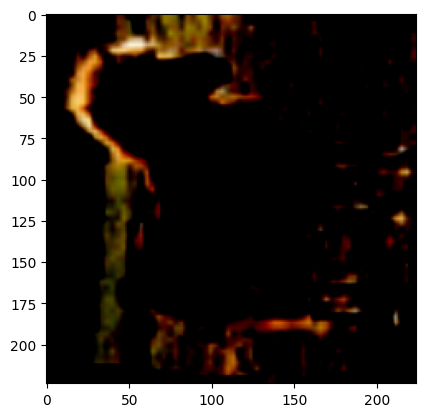

In [48]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [49]:
count_class = {}
for _,outs in dataset:
    labels = classes[outs]
    if labels not in count_class:
        count_class[labels] = 0
    count_class[labels] += 1
count_class

{'horse': 200,
 'cat': 200,
 'car': 200,
 'ship': 200,
 'monkey': 200,
 'dog': 200,
 'airplane': 200,
 'bird': 200,
 'truck': 200,
 'deer': 200}

### Data Split

In [50]:
val_size = 400
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1600, 400)

#### Data Loader

In [51]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=0, pin_memory=True)

#### Examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 3, 224, 224])


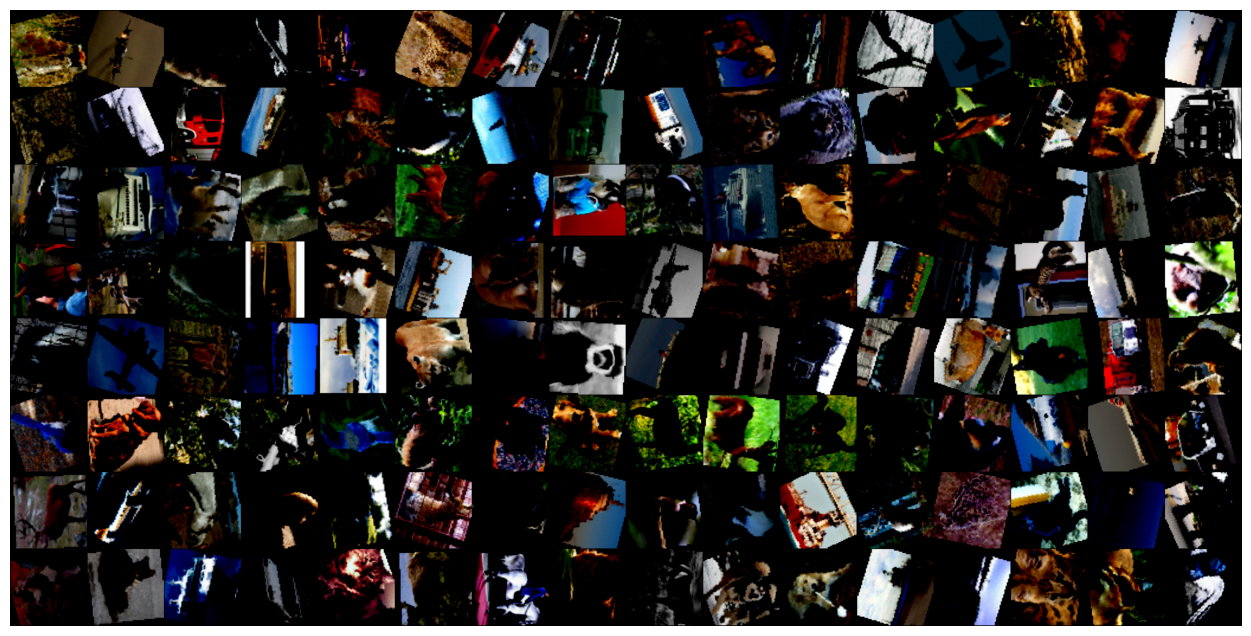

In [52]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Define Models

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      # loss += loss_fn(model(batchX), batchY)
      loss += loss_fn(model(batchX).logits, batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [54]:
def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        # outputs = model(batchX)  # feed batch to the model
        outputs = model(pixel_values=batchX.float()).logits
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

In [55]:
import time
import copy
def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, weight_decay=0, lr=0.001):
  # Move the model to the device before initializing the optimizer
  model.to(device)
  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=weight_decay) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer

  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=num_epochs, T_mult=2)

  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()
  history['best_val'] = 0
  history['best_model'] = None

  for epoch in range(num_epochs):
      start = time.time()
      model.train()
      for (X, y) in train_loader:
          # Move input data to the same device as the model
          X,y = X.to(device), y.to(device)
          # Forward pass
          # outputs = model(X.type(torch.float32))
          outputs = model(pixel_values=X.type(torch.float32)).logits
          loss = loss_fn(outputs, y.type(torch.long))
          # Backward and optimize
          optim.zero_grad()
          loss.backward()
          optim.step()

      # Update learning rate
      scheduler.step()

      #losses and accuracies for epoch
      val_loss = compute_loss(model, loss_fn, valid_loader)
      val_acc = compute_acc(model, valid_loader)
      train_loss = compute_loss(model, loss_fn, train_loader)
      train_acc = compute_acc(model, train_loader)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      if val_acc > history['best_val']:
        print('Best val acc change:', val_acc)
        history['best_val'] = val_acc
        history['best_model'] = copy.deepcopy(model.state_dict())

      end = time.time()
      print(f"total time for each epoch {end - start}") # time in seconds
      if not verbose: #verbose = True means we do show the training information during training
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%", end="")
        print(f"- lr - {optim.param_groups[0]['lr']}")
  return history

## Training the Model

### Model Selection

In [56]:
# class CNN(nn.Module):
#     def __init__(self, num_classes=10):
#         super(CNN, self).__init__()

#         # 1st Conv layer: in_channels=3, out_channels=32, kernel=3x3
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

#         # 2nd Conv layer: in_channels=32, out_channels=64, kernel=3x3
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

#         # MaxPooling reduces spatial size (64→32→16 after 2 pools)
#         self.pool  = nn.MaxPool2d(2, 2)

#         # Fully connected: input 64×16×16 → output num_classes
#         self.fc    = nn.Linear(64 * 16 * 16, num_classes)

#     def forward(self, x):
#         # Conv layer 1
#         x = self.pool(F.relu(self.conv1(x)))

#         # Conv layer 2
#         x = self.pool(F.relu(self.conv2(x)))

#         # Flatten
#         x = x.view(x.size(0), -1)

#         # FC layer
#         x = self.fc(x)
#         return x

# model = CNN().to(device)

In [57]:
from transformers import ViTForImageClassification

# Load a pretrained ViT (patch size 16, pretrained on ImageNet-1k)
model = ViTForImageClassification.from_pretrained(
    "WinKawaks/vit-tiny-patch16-224"
)
for param in model.vit.parameters():
  param.requires_grad=False
# Change the classifier head to match your 10 output classes
model.classifier = nn.Linear(model.classifier.in_features, 10)

#### <span style="color:#0b486b">4. Declaring the Loss, Optimizer, learning rate and Training the Model </span>

In [58]:
from torch import optim
optim_dict = {"Adam":optim.Adam, "Adadelta":optim.Adadelta, "Adagrad":optim.Adagrad,
              "Adamax":optim.Adamax, "AdamW": optim.AdamW, "ASGD":optim.ASGD,
              "NAdam":optim.NAdam, "RMSprop":optim.RMSprop, "RAdam":optim.RAdam,
              "Rprop": optim.Rprop, "SGD":optim.SGD}


# Loss and optimizer
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim_dict["Adam"](model.parameters(), lr=learning_rate)

#dnn_model = model
history = fit(model=model, train_loader=train_loader, valid_loader = valid_loader,
    optimizer = optimizer, num_epochs= 15, verbose = False, lr=learning_rate)

Best val acc change: 0.2725
total time for each epoch 8.989015102386475
Epoch 1/15
train loss= 2.3518 - train acc= 25.69% - valid loss= 2.2148 - valid acc= 27.25%- lr - 0.0009890738003669028
Best val acc change: 0.46
total time for each epoch 8.800686597824097
Epoch 2/15
train loss= 1.6467 - train acc= 43.38% - valid loss= 1.5391 - valid acc= 46.00%- lr - 0.0009567727288213005
Best val acc change: 0.54
total time for each epoch 8.697957038879395
Epoch 3/15
train loss= 1.3010 - train acc= 54.06% - valid loss= 1.1553 - valid acc= 54.00%- lr - 0.0009045084971874737
Best val acc change: 0.6525
total time for each epoch 8.902474880218506
Epoch 4/15
train loss= 1.0805 - train acc= 61.62% - valid loss= 1.1117 - valid acc= 65.25%- lr - 0.0008345653031794292
Best val acc change: 0.6625
total time for each epoch 8.974757194519043
Epoch 5/15
train loss= 0.9621 - train acc= 64.06% - valid loss= 0.8934 - valid acc= 66.25%- lr - 0.00075
Best val acc change: 0.685
total time for each epoch 8.95544052

In [59]:
# 1) Copy best weights to CPU (so we can safely free GPU)
best_model_cpu = {k: v.cpu() for k, v in history['best_model'].items()}

# 2) Proactively delete GPU-resident objects
objs = ["model", "optim", "optimizer", "scheduler", "outputs", "loss"]
for name in objs:
    if name in globals():
        try:
            del globals()[name]
        except Exception:
            pass

# 3) Run GC + clear CUDA cache
import gc, torch
gc.collect()
torch.cuda.empty_cache()

# (optional) collect inter-process handles if used anywhere
if hasattr(torch.cuda, "ipc_collect"):
    torch.cuda.ipc_collect()

In [60]:
# eval_model = create_model().to(device)
# eval_model = CNN().to(device)

# Free GPU cache before validation
torch.cuda.empty_cache()
# Load a pretrained ViT (patch size 16, pretrained on ImageNet-1k)
eval_model = ViTForImageClassification.from_pretrained(
    "WinKawaks/vit-tiny-patch16-224"
)

# Change the classifier head to match your 10 output classes
eval_model.classifier = nn.Linear(eval_model.classifier.in_features, 10)

eval_model.load_state_dict(history['best_model'])
eval_model.to(device)
# eval_model.load_state_dict({k: v.cpu() for k, v in history['best_model'].items()})
best_val = compute_acc(eval_model, valid_loader)
print(f"Best validation accuracy: {best_val*100:.2f}% -- {history['best_val']}")

Best validation accuracy: 71.00% -- 0.7425


#### <span style="color:#0b486b">5. Visualizing the Performance and Loss Objective Function </span>

There are four keys in the history dictionary: `train_loss` and `val_loss` measure the loss on the training set and the validation set, respectively, while `train_acc` and `val_acc` measure the accuracy on the training set and the validation set.  
The following figure visualize all four metrics with two y-axes, losses (blue lines, in descending) and accuracies (red lines, in asending)


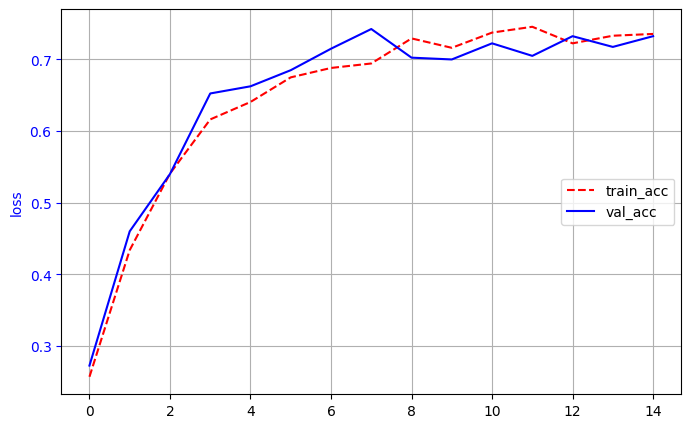

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

his = history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['train_acc'], 'r--',label='train_acc')
ln2 = ax.plot(his['val_acc'], 'b-',label='val_acc')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=7)
plt.grid(True)
plt.show()

# Evaluate model on the testing set, get the csv file and upload to kaggle website.

In [62]:
import torch
import pandas as pd

def save_prediction_to_csv(model, loader, device, output_file="submission.csv"):
    model.eval()
    predictions = []
    image_ids = []
    df = {
    "ImageId": [],
    "Label": []
    }
    total = 0
    with torch.no_grad():
        for i, (batchX, _ ) in enumerate(loader):
            batchX = batchX.to(device)
            # outputs = model(batchX.float())  # Convert to float32 and feed batch to the model
            outputs = model(pixel_values=batchX.float()).logits

            predicted = torch.argmax(outputs, dim=1)  # Get the predicted class
            total += predicted.size(0)
            for ids, pred in enumerate(predicted):
                df["Label"].append(pred.cpu().item())
    df["ImageId"] = [i+1 for i in range(total)]
    # Create a DataFrame
    df = pd.DataFrame(df)
    # Save to CSV
    df.to_csv(output_file, index=False)

save_prediction_to_csv(eval_model, test_loader, device, output_file="submission.csv")

KeyboardInterrupt: 

# Upload result to kaggle competition

## Regsiter Kaggle account
## Join the competition via Link on Moodle
## Upload the submission.csv file to the kaggle website to get your results

## Rules

*   No late submissions are allowed.
*   Students must compete in groups. Only group scores shown on Kaggle that count.
